# Image Classifier


In [1]:
# Imports here
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load the data
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                         transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
train_datasets = datasets.ImageFolder(train_dir, transform = train_transforms)
valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloaders = torch.utils.data.DataLoader(train_datasets, batch_size=64, shuffle = True)
validloaders = torch.utils.data.DataLoader(valid_datasets, batch_size=64, shuffle = True)
testloaders = torch.utils.data.DataLoader(test_datasets, batch_size=64, shuffle = True)

### Label mapping


In [4]:
# a dictionary mapping the integer encoded categories to the actual names of the flowers.

import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier


In [8]:
# Build and train the network
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg19_bn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:20<00:00, 27814007.35it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [9]:
for param in model.parameters():
    param.requires_grad=False

    
model.classifier=nn.Sequential(nn.Linear(25088, 512),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(512, 102),
                               nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [10]:
epochs = 2
step =0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloaders:
        step +=1
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(images)
        loss = criterion (logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                valid_loss = 0
                for images, labels in validloaders:
                    images, labels = images.to(device), labels.to(device)
                
                    logps = model.forward(images)
                    
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class =ps.topk(1,dim=1)
                    equals=top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloaders):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloaders):.3f}")
            running_loss = 0
            model.train()
                    


Epoch 1/2.. Train loss: 4.625.. Validation loss: 4.309.. Validation accuracy: 0.146
Epoch 1/2.. Train loss: 4.282.. Validation loss: 3.801.. Validation accuracy: 0.230
Epoch 1/2.. Train loss: 3.874.. Validation loss: 3.396.. Validation accuracy: 0.306
Epoch 1/2.. Train loss: 3.706.. Validation loss: 3.016.. Validation accuracy: 0.380
Epoch 1/2.. Train loss: 3.326.. Validation loss: 2.618.. Validation accuracy: 0.441
Epoch 1/2.. Train loss: 2.920.. Validation loss: 2.325.. Validation accuracy: 0.489
Epoch 1/2.. Train loss: 2.774.. Validation loss: 1.989.. Validation accuracy: 0.558
Epoch 1/2.. Train loss: 2.514.. Validation loss: 1.775.. Validation accuracy: 0.606
Epoch 1/2.. Train loss: 2.475.. Validation loss: 1.542.. Validation accuracy: 0.648
Epoch 1/2.. Train loss: 2.210.. Validation loss: 1.408.. Validation accuracy: 0.685
Epoch 1/2.. Train loss: 2.093.. Validation loss: 1.347.. Validation accuracy: 0.688
Epoch 1/2.. Train loss: 1.982.. Validation loss: 1.174.. Validation accuracy

## Testing your network


In [7]:
# TODO: Do validation on the test set
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()

test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloaders:
        images, labels = images.to(device), labels.to(device)
        logps = model.forward(images)
                    
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()
                    
        ps = torch.exp(logps)
        top_p, top_class =ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
    print(f"Test loss: {test_loss/len(testloaders):.3f}.. "
          f"Test accuracy: {accuracy/len(testloaders):.3f}")


Test loss: 0.429.. Test accuracy: 0.877


## Save the checkpoint


In [12]:
checkpoint= {'model': model,
            'state_dict': model.state_dict(),
            'epochs': epochs,
            'optimizer': optimizer.state_dict}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint


In [1]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    checkpoint=torch.load(filename)
    model=checkpoint['model']
    model.load_state_dict (checkpoint['state_dict'])
    optimizer= checkpoint['optimizer']
    epochs=checkpoint['epochs']
    return model, epochs, optimizer

In [6]:
model, epochs, optimizer =load_checkpoint('checkpoint.pth')

# Inference for classification



## Image Preprocessing


In [17]:
from PIL import Image
import numpy as np
    
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    image = Image.open(image)
    image= image.resize((224, 224))
    #box=(224, 224, 224, 224)
    #image= image.crop(box)
    
    image = np.array(image)
       
    image = np.divide(image,255)
    mean= np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])

    image= (image - mean)/ std
    
    image = image.transpose((2 ,0 ,1))
    image= torch.from_numpy(image)
    model.to('cpu')

    return image


To check my work, the function below converts a PyTorch tensor and displays it in the notebook. To check if my `process_image` function works, running the output through this function should return the original image.

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image= image.numpy()
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

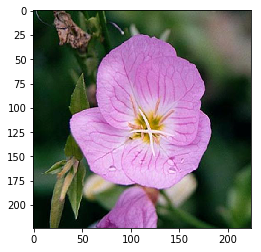

In [19]:
file_path = 'flowers/train/1/image_06734.jpg'
imshow(process_image(file_path))

## Class Prediction


In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    #model.to('cpu')
    model.eval()
    model.float()
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    
    image = image.type(torch.FloatTensor)
    image=torch.unsqueeze(image,dim=0)
    
    #print(image.shape)
    logps = model.forward(image)
    ps= torch.exp(logps)
    probs, classes = ps.topk(topk, dim=1)
    
    return probs, classes


In [21]:
file_path = 'flowers/train/1/image_06734.jpg'

probs, classes = predict(file_path, model)
classes = classes +1
print(probs)
print(classes)

tensor([[ 0.2503,  0.1384,  0.0931,  0.0819,  0.0784]])
tensor([[  1,  51,  86,  14,  62]])


## Sanity Checking



In [24]:
probs_np=probs.detach().numpy()
max_index = np.argmax(probs_np)
max_probability = probs[max_index]
label = classes[0][max_index]
label_np=label.numpy()
classes_np=classes.numpy()


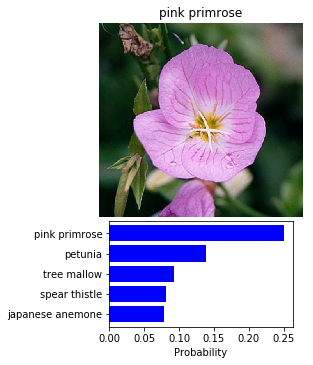

In [25]:
# Display an image along with the top 5 classes


fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)
#print (z)
image = Image.open(file_path)
ax1.axis('off')
ax1.set_title(cat_to_name[str(label_np)])
ax1.imshow(image)

labels = []
for i in classes_np[0]:
    labels.append(cat_to_name[str(i)])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, probs_np[0], xerr=0, align='center', color='blue')

plt.show()